In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 这一行注释掉就是使用gpu，不注释就是使用cpu

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


def initialization(seed=42):
    keras.backend.clear_session()
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [3]:
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname='../Fonts/SourceHanSerifSC-Medium.otf', size=14)

# 循环神经元和层 Recurrent Neurons and Layers

`循环神经网络`(Recurrent Neural Network，RNN)是一类具有短期记忆能力的神经网络.在循环神经网络中，神经元不但可以接受其他神经元的信息，也可以接受自身的信息，形成具有环路的网络结构.

和前馈神经网络相比，循环神经网络更加符合生物神经网络的结构.循环神经网络已经被广泛应用在语音识别、语言模型以及自然语言生成等任务上.

循环神经网络的参数学习可以通过`随时间反向传播算法`来学习.随时间反向传播算法即按照时间的逆序将错误信息一步步地往前传递.当输入序列比较长时，会存在梯度爆炸和消失问题，也称为`长程依赖问题`.为了解决这个问题，人们对循环神经网络进行了很多的改进，其中最有效的改进方式引入`门控机制`(Gating Mechanism).


- `简单循环网络`(Simple Recurrent Network，SRN)是一个非常简单的循环神经网络，只有一个隐藏层的神经网络。在一个两层的前馈神经网络中，连接存在相邻的层与层之间，隐藏层的节点之间是无连接的。而简单循环网络增加了从隐藏层到隐藏层的反馈连接.

- 如果我们把每个时刻的状态都看作前馈神经网络的一层，循环神经网络可以看作**在时间维度上权值共享**的神经网络。图6.2即下图右侧给出的`按时间展开的循环神经网络`。每个时间步长为$t$,循环神经元接受输入$x_{(t)}$和前一个时间步长$y_{(t-1)}$的输出.
<img src="../images/other/15-1.png" width="400">
- 循环神经网络的拟合能力十分强大,一个完全连接的循环网络是任何非线性动力系统的近似器。

>- 单个实例的循环层输出:
>
> $$
y_{(t)} = f(W^T_xx_{(t)}+W^T_yy_{(t-1)}+b)
$$
$f(·)$为非线性激活函数

在简单RNN中随机初始化参数时使用Sigmoid激活函数会比使用ReLU激活函数更好一些,但是**使用单位矩阵初始化使用ReLu激活函数更好一些.**

> - 小批量中所有实例的循环神经元层输出:
> $$
\begin{aligned} Y_{(t)} 
&=f(W^T_xX_{(t)}+W^T_yY_{(t-1)}+b)) \\ 
&=f(X_{(t)}W_x+Y_{(t-1)}W_y+b) \\
&=f([X_{(t)}Y_{(t-1)}]W+b)\end{aligned}
$$
其中:$\mathbf{W}=\left[\begin{array}{l}{W}_{x} \\ {W}_{y}\end{array}\right]$


- 由于循环神经元在时间步长$t$时的输出,是来自先前时间步的所有输入的函数，在时间步长上保留某些状态的神经网络的一部分称为`记忆单元`.

循环神经网络可以应用到很多不同类型的机器学习任务。根据这些任务的 特点可以分为以下几种模式：
1. 序列到类别模式

    - 主要用于序列数据的**分类问题**：输入为序列，输出为类别
    - 应用:情感分析,关键词挖掘


2. 同步的序列到序列模式
    
    - 用于序列标注:每一时刻都有输入和输出,输入和输出长度相同
    
    
3. 异步的序列到序列模式
    
    - 也称为`编码器-解码器(Encoder-Decoder)模型`，即 输入序列和输出序列不需要有严格的对应关系，也不需要保持相同的长度。
    - 比如 在机器翻译中，输入为源语言的单词序列，输出为目标语言的单词序列.
    - 先将样本x按不同时刻输入到一个循环神经网络（编码器)中，并得到其编码$h_T$。然后再使用另一个循环神经网络（解码器），得到输出序列$y_{1：M}$ .
    <img src="../images/other/15-2.png" width="500">

# 训练RNN Training RNNs

在循环神经网络中主要有两种计算梯度的方式：`随时间反向传播(BPTT)算法`和`实时循环学习(RTRL)算法`.

- `随时间反向传播`(BackPropagation Through Time，BPTT)算法的主要思想是通过类似前馈神经网络的误差反向传播算法来计算梯度.
    
    BPTT算法将循环神经网络看作一个展开的多层前馈网络，其中“每一层”对应循环网络中的“每个时刻”。这样，循环神经网络就可以按照前馈网络中的反向传播算法计算参数梯度。在“展开”的前馈网络中，所有层的参数是共享的，因此参数的真实梯度是所有“展开层”的参数梯度之和。
    
<img src="../images/other/15-3.jpg">

# 预测时间序列 Forcecasting a Time Serise

数据是每个时间步长一个或多个值的序列称为`时间序列`.
- 典型的任务是预测未来值,这称为`预测(forecasting)`.
- 预测过去的缺失值,这称为`插补(imputation)`.

例: 3个单变量时间序列, 每个时间序列的长度是50个时间步长,目标是预测他们的下一个时间步长的值

1. 生成时间序列: 每个序列是两个 固定振幅 但 频率和相位随机 的正弦波综总和

In [4]:
def generate_time_series(batch_size, n_steps):
    """
    :param batch_size: 批处理大小
    :param n_steps: 每个序列的长度
    :param return: 返回形状为[批处理大小, 时间步长, 1]的NumPy数组
    """
    # np.random.rand(): 当函数括号内有两个及以上参数时，则返回对应维度的数组，能表示向量或矩阵；
    freq_1, freq_2, offsets_1, offsets_2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets_1) * (freq_1 * 10 + 10))    #   wave_1
    series += 0.2 * np.sin((time - offsets_2) * (freq_2 * 20 + 20))   # + wave_2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)       # + noise
    
    return series[..., np.newaxis].astype(np.float32)

- 处理时间序列时,输入特征通常表示为 [`batch_size`, `time_steps`, `维度`],其中多变量时间序列维度更多.

In [5]:
initialization(seed=42)

In [6]:
n_steps = 50
series = generate_time_series(batch_size=10000, n_steps=n_steps+1) # shape:(10000, 51, 1)

2. 创建训练集,验证集和测试集

In [7]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]   
X_val, y_val = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

- X_train中包含7000个时间序列.由于我们为**每个序列预测一个值**,因此目标是列向量

3. 绘制时间序列

In [8]:
def plot_series(series,
                y=None,
                y_pred=None,
                x_label="$t$",
                y_label="$x_{(t)}$",
                legend=True):
    plt.plot(series, "r.-")
    if y is not None:
        plt.plot(n_steps, y, "b*", markersize=10, label="目标")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="预测")

    if x_label is not None:
        plt.xlabel(x_label, fontsize=16)
    if y_label is not None:
        plt.ylabel(y_label, fontsize=16, rotation=0, labelpad=15)

    if legend and (y or y_pred):
        plt.legend(loc="upper left", prop=my_font)

    plt.hlines(0, 0, n_steps, linewidth=1)
    plt.grid(True)
    plt.axis([0, n_steps + 5, -1, 1])

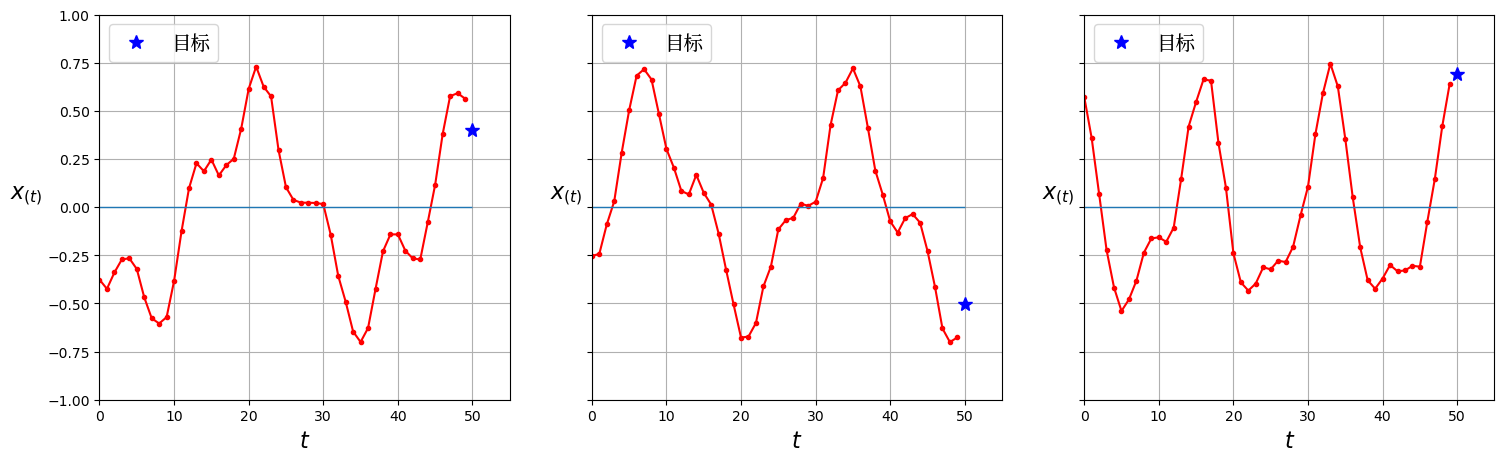

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(18, 5))
for col in range(3):
    plt.sca(axes[col])  # 将当前的轴设置为axes[col]
    plot_series(
        series=X_val[col, :, 0],  # 以验证集第一个时间序列为例
        y=y_val[col, 0])
plt.show()

- 蓝星代表目标,红叉代表预测.

## 基准指标 Baseline Metrics

### 仅预测每个序列最后一个值

In [10]:
y_pred = X_val[:, -1]  # shape:(2000, 1)

np.mean(keras.losses.mean_squared_error(y_true=y_val, y_pred=y_pred))

2022-11-01 15:07:13.834171: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-01 15:07:13.834196: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: jin
2022-11-01 15:07:13.834200: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: jin
2022-11-01 15:07:13.834259: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-11-01 15:07:13.834273: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-11-01 15:07:13.834277: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-11-01 15:07:13.834692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performanc

0.020211367

- 绘制时间序列

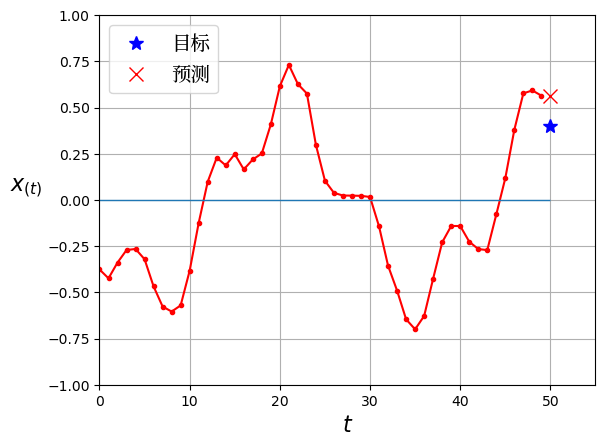

In [11]:
plot_series(series=X_val[0, :, :], y=y_val[0, :], y_pred=y_pred[0, 0])

### 利用全连接网络实现线性预测

In [12]:
initialization()

In [13]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(1)
])

In [14]:
model.compile(loss="mse",
              optimizer="adam")

history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_val, y_val))

Epoch 1/20
219/219 [==============================] - 0s 872us/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 623us/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 642us/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 617us/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 564us/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 580us/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 565us/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 586us/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 572us/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 564us/step - loss: 0.006

In [15]:
model.evaluate(X_val, y_val)

63/63 [==============================] - 0s 401us/step - loss: 0.0042


0.004168087150901556

- 在每个 epoch 结束时计算验证误差，而在每个 epoch 期间使用运行平均值计算训练误差。因此绘制训练曲线时，应该**向左移动半个epoch**.

In [16]:
def plot_lr_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) - 0.5, loss, "b-", label="训练误差")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="验证误差")

    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14, prop=my_font)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.axis([1, 10, 0, 0.05])

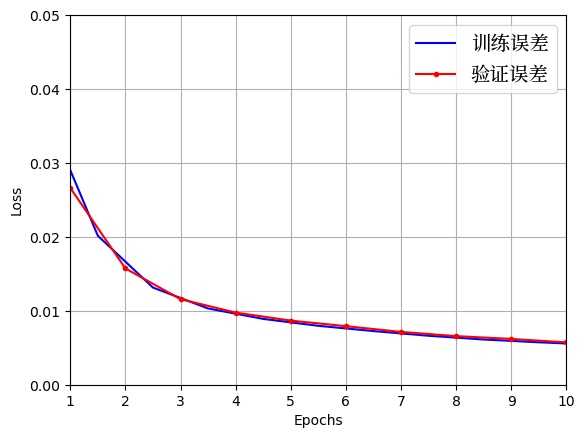

In [17]:
plot_lr_curves(loss=history.history["loss"],
               val_loss=history.history["val_loss"])

plt.show()

- 为了更清晰的演示，让我们将上述曲线向右移动加1.

In [18]:
def plot_lr_curves(loss, val_loss, max_epoches=10):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b-", label="训练误差")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="验证误差")

    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14, prop=my_font)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

    plt.axis([1, max_epoches, 0, 0.05])

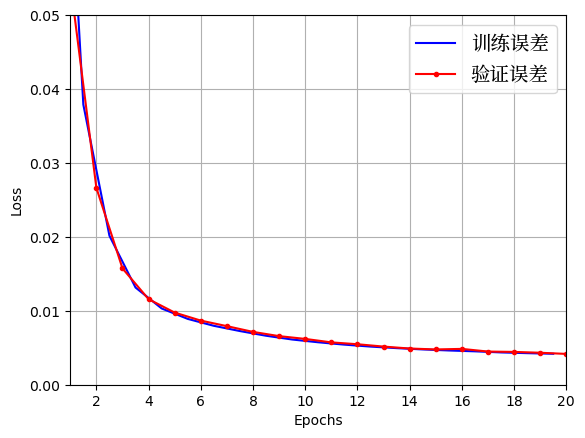

In [19]:
plot_lr_curves(loss=history.history["loss"],
               val_loss=history.history["val_loss"],
               max_epoches=20)
plt.show()

- 绘制时间序列

63/63 [==============================] - 0s 373us/step


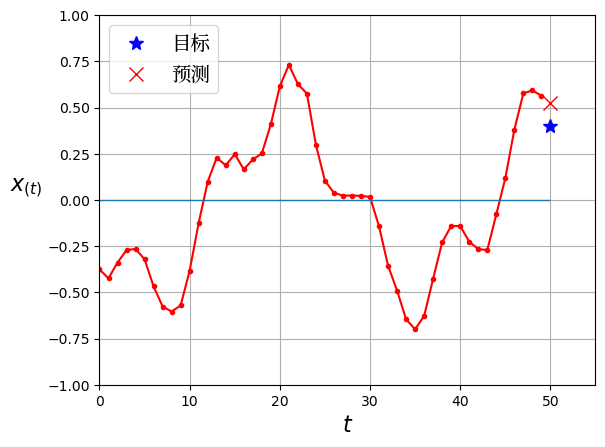

In [20]:
y_pred = model.predict(X_val)
plot_series(series=X_val[0, :, :], y=y_val[0, :], y_pred=y_pred[0, 0])
plt.show()

## 实现一个简单的RNN Implementing a Simple RNN

<img src="../images/other/15-4.png" width="400">

- 使用`SimpleRNN` 定义循环层，类似于输出到输出循环,实现简单RNN.
     
     - 默认:`use_bias=True`, `return_sequences=False`
     - 要是**每个时间步长返回一个输出**,需`return_sequences=True`
     - 默认`SimpleRNN`使用`tanh激活函数`.
     $$ tanh(x) = 2f(2x)-1= \frac{e^x-e^{-x}}{e^x+e^{-x}}$$
     - 无需执行输入序列的长度,因为RNN可以处理任意数量的时间步长.因此将第一个输入的维度设置为`[None,1]`.
         <img src="../images/other/15-5.png" width="300">
     

In [21]:
initialization(seed=42)

In [22]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [23]:
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.005))
# `adam`默认学习率为0.001，这里将它增加到 0.005.

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    validation_data=(X_val, y_val))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0116 - val_loss: 0.0110

In [24]:
model.evaluate(X_val, y_val)

63/63 [==============================] - 0s 1ms/step - loss: 0.0109


0.010881561785936356

评估这个模型发现它的 `MSE` 仅达到 0.01，因此它比方法1更好(0.020)，但它并没有击败简单的线性模型(0.004).

- 绘制时间序列

63/63 [==============================] - 0s 1ms/step


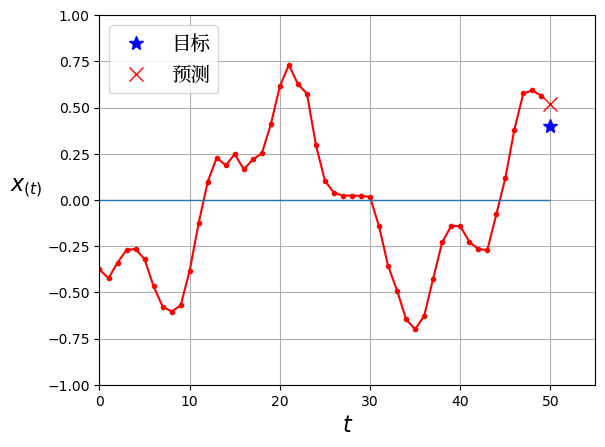

In [25]:
y_pred = model.predict(X_val)
plot_series(series=X_val[0, :, :], y=y_val[0, :], y_pred=y_pred[0, 0])

还有很多模型可以预测时间序列,比如:`加权移动平均模型`(weighted moving average models),`自回归移动平均模型`(autoregressive integrated moving average, ARIMA).其中要求你删除趋势和季节性.
1. 例如研究网站的活动用户数,其中该数字以每个月10%的速度进行增长.需要在时间序列中移除这种`趋势`.一旦模型完成训练并开始预测,就需要将`趋势`添加回来得到最后的预测.
2. 例如预测防晒霜的每月销售数量,可以观察到强烈的`季节性`.需要在时间序列中移除这种`季节性`.

## 深度RNN Deep RNNs

把很多层单元堆叠起来是很普遍的,如下图所示为深度RNN以及随时间展开.

<img src="../images/other/15-6.png" width="400">

- 使用`SimpleRNN`层进行堆叠就可实现深度RNN

### 最后一层使用SimpleRNN层

In [26]:
initialization(seed=42)

In [27]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    validation_data=(X_val, y_val))

Epoch 1/20
219/219 [==============================] - 3s 11ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0035 - val_lo

- **确保为所有循环层设置`return_sequences=True`**（除了最后一个，如果你只关心最后一个输出）。如果你不这样做，他们将输出一个二维数组（仅包含最后一个时间步的输出),而不是一个三维数组(包含所有时间步长的输出),这样在下一个循环会报错.
> $Y_{(t)}$是一个$m×n_{neurons}$矩阵, 包含在小批量处理中 每个实例 在时间步长t时 在该层的输出
>
>$m$是小批量处理中的实例数量,$n_{neurons}$是神经元数量

In [28]:
model.evaluate(X_val, y_val)

63/63 [==============================] - 0s 3ms/step - loss: 0.0029


0.002910564187914133

评估这个模型发现它的 MSE 仅达到 0.003，因此它比方法1(0.020)，和简单的线性模型(0.004)都要好.

- 绘制学习曲线

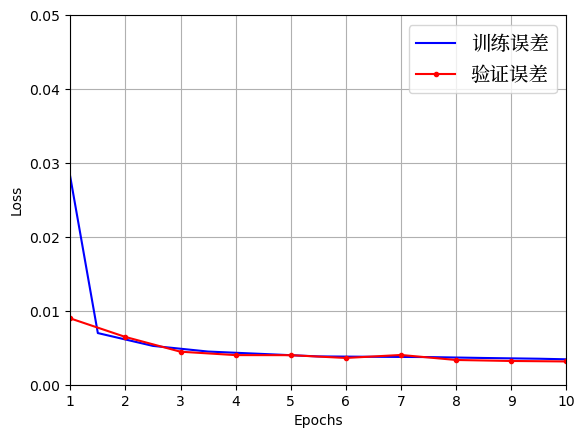

In [29]:
plot_lr_curves(loss=history.history["loss"], val_loss=history.history["val_loss"])
plt.show()

- 绘制时间序列

63/63 [==============================] - 0s 3ms/step


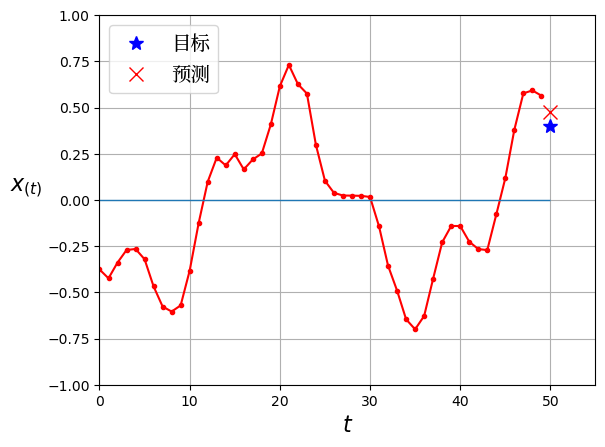

In [30]:
y_pred = model.predict(X_val)

plot_series(series=X_val[0, :, :], y=y_val[0, 0], y_pred=y_pred[0, 0])

### 最后一层使用Dense层

- 由于预测单变量时间序列,`RNN`将主要使用其他循环层的隐藏状态来传递其所需的所有信息，而不会使用在最终层的隐藏状态.
- `SimpleRNN`默认使用`tanh激活函数`.如果不使用`tanh激活函数`,而使用其他激活函数.

因此将输出层替换为`Dense`层, 并且确保最后一个RNN层删除`return_sequences=True`.

In [31]:
initialization(seed=42)

In [32]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),  # 多对一 或 序列到向量
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    validation_data=(X_val, y_val))

Epoch 1/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0030 - val_loss: 0.0029

In [33]:
model.evaluate(X_val, y_val)

63/63 [==============================] - 0s 2ms/step - loss: 0.0026


0.002623624401167035

可以发现, 对比前面的例子, 收敛更快且性能一样好.

- 绘制学习曲线

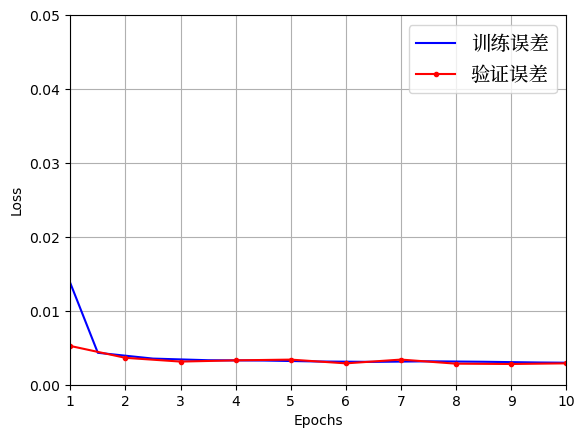

In [34]:
plot_lr_curves(loss=history.history["loss"], val_loss=history.history["val_loss"])
plt.show()

- 绘制时间序列

63/63 [==============================] - 0s 2ms/step


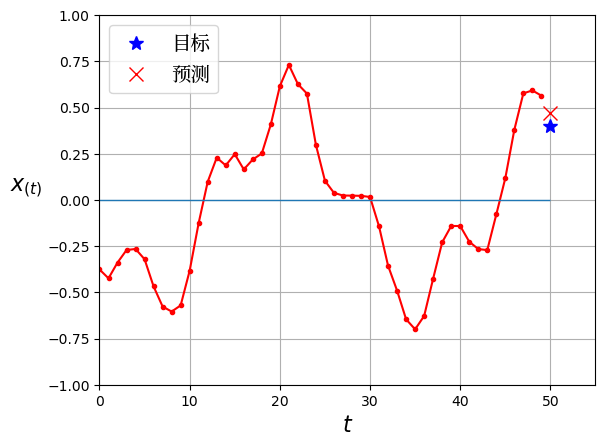

In [35]:
y_pred = model.predict(X_val)

plot_series(series=X_val[0, :, :], y=y_val[0, 0], y_pred=y_pred[0, 0])

- 保存模型

In [36]:
model.save("../models/deepRNNs_base.h5")

## 预测未来几个时间步长 Forecasting Serveral Time Steps Ahead

我们可以很容易的通过适当的修改目标来实现预测未来的几个值.

### 使用RNN一次一步预测策略

#### 使用滑动窗口的递归多步预测策略

**方法:使用已经训练的模型,使其预测下一个值,然后将这个值添加到输入中,再预测模型的后面的值,以此类推.**

1. 加载模型

In [37]:
initialization(seed=42)
model = keras.models.load_model("../models/deepRNNs_base.h5")

2. 生成时间序列

In [38]:
def generate_time_series(batch_size, n_steps):
    """
    :param batch_size: 批处理大小
    :param n_steps: 每个序列的长度
    :param return: 返回形状为[批处理大小, 时间步长, 1]的NumPy数组
    """
    freq_1, freq_2, offsets_1, offsets_2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets_1) * (freq_1 * 10 + 10))    #   wave_1
    series += 0.2 * np.sin((time - offsets_2) * (freq_2 * 20 + 20))   # + wave_2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)       # + noise
    
    return series[..., np.newaxis].astype(np.float32)

In [39]:
np.random.seed(seed=43)   # 不是42 用于训练集

In [40]:
n_steps = 50
ahead = 10
series = generate_time_series(batch_size=1, n_steps=n_steps + ahead)   # shape:(1, 60, 1)

X_new, y_new = series[:, :n_steps], series[:, n_steps:]
X_new.shape, y_new.shape

((1, 50, 1), (1, 10, 1))

3. 预测提前 10 步，一次 1 步；然后将维度扩展到`[批量大小，时间步长，维度]`.

In [41]:
def pred_ahead(type, X, ahead):
    for step_ahead in range(ahead):
        y_pred_one = model.predict(X[:, step_ahead:])  # shape:(1, 1)    预测下一个值
        y_pred_one_expand = y_pred_one[:, np.newaxis, :]  # shape:(1, 1, 1) 拓展维度

        X = np.concatenate([X, y_pred_one_expand],
                           axis=1)  # axis=1:表示合并后第二个维度(时间步长)数据要变
        # X.shape:(1, 51, 1) --> (1, 60, 1)

    if type == "train":
        y_pred = X[:, n_steps:]      #  50:60 --> shape:(1, 10, 1)
    elif type == "valid":
        y_pred = X[:, n_steps:, 0]   #  shape:(2000, 10)
    
    return y_pred

In [42]:
y_pred = pred_ahead(type="train", X=X_new, ahead=ahead)
y_pred.shape

1/1 [==============================] - 0s 10ms/step


(1, 10, 1)

4. 绘制时间序列

In [43]:
def plot_multiple_forecasts(X, y=None, y_pred=None):
    n_steps = X.shape[1]   # X_new: 50
    ahead = y.shape[1]     # y_new: 10
    all_steps = n_steps + ahead  # n_steps+ahead -> 50+10=60
    
    plot_series(series=X[0, :, 0])
    
    plt.plot(np.arange(n_steps, all_steps), y[0,:,0], "yo-", label="实际")  
    plt.plot(np.arange(n_steps, all_steps), y_pred[0,:,0], "bx-", label="预测")  
   
    plt.legend(loc="lower left", prop=my_font)

    plt.axis([0, all_steps , -1, 1])   

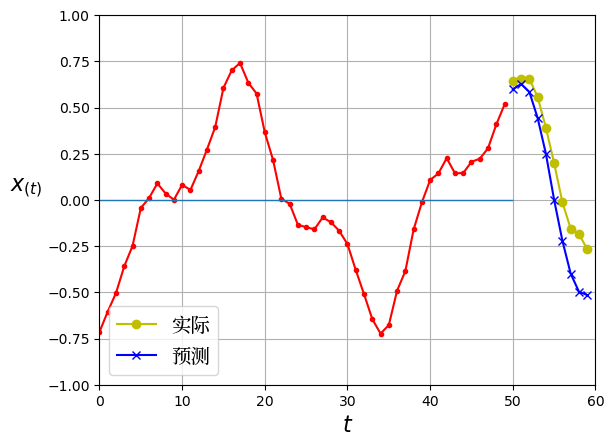

In [44]:
plot_multiple_forecasts(X=X_new, y=y_new, y_pred=y_pred)
plt.show()

可以观察到,由于误差可能会累积,因此对下一步 长的预测 通常会比对 未来几个时间步长 的预测更为准确.

4. 使用**验证集**在这个模型来预测接下来的 10 个值。

In [45]:
series = generate_time_series(batch_size=10000,
                              n_steps=n_steps + ahead)  # shape:(10000, 60, 1)

X_val, Y_val = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]

X_val.shape, Y_val.shape

((2000, 50, 1), (2000, 10))

In [46]:
Y_pred = pred_ahead(type="valid", X=X_val, ahead=ahead)  # 使用验证集
Y_pred.shape

63/63 [==============================] - 0s 2ms/step


(2000, 10)

In [47]:
np.mean(keras.losses.mean_squared_error(Y_val, Y_pred))

0.025939876

#### 递归多步预测策略

**方法:使用整个数据集进行预测,其他同方法1**

In [48]:
model = keras.models.load_model("../models/deepRNNs_base.h5")

In [49]:
initialization(seed=43)

n_steps = 50
ahead = 10
series = generate_time_series(batch_size=1, n_steps=n_steps + ahead)   # shape:(1, 60, 1)

X_new, y_new = series[:, :n_steps], series[:, n_steps:]

In [50]:
def pred_ahead(type, X, ahead):
    for step_ahead in range(ahead):
        y_pred_one = model.predict(X)      # ❤ 使用整个数据集
        y_pred_one_expand = y_pred_one[:, np.newaxis, :]      

        X = np.concatenate([X, y_pred_one_expand], axis=1) 

    if type == "train":
        y_pred = X[:, n_steps:]      
    elif type == "valid":
        y_pred = X[:, n_steps:, 0]   
    
    return y_pred

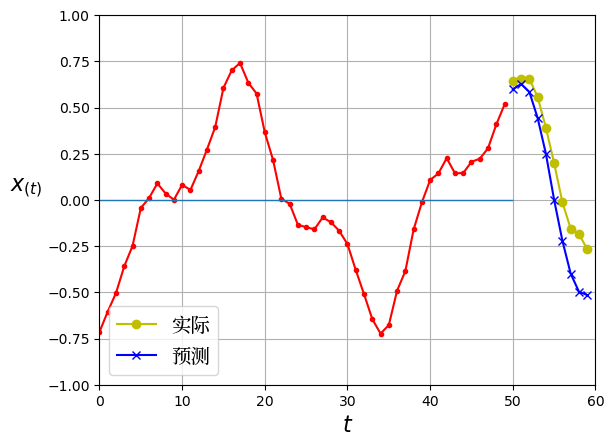

In [51]:
plot_multiple_forecasts(X=X_new, y=y_new, y_pred=y_pred)
plt.show()

使用验证集在这个模型来预测接下来的 10 个值。

In [52]:
series = generate_time_series(batch_size=10000,
                              n_steps=n_steps + ahead)  # shape:(10000, 60, 1)

X_val, Y_val = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]

In [53]:
Y_pred = pred_ahead(type="valid", X=X_val, ahead=ahead)  # 使用验证集
Y_pred.shape

63/63 [==============================] - 0s 2ms/step


(2000, 10)

In [54]:
np.mean(keras.losses.mean_squared_error(Y_val, Y_pred))

0.027924491

---

`方法1`: 整个数据集（包括原始数据+渐进数据`X_new`）

`方法2`: 定长数据集（原始数据后半部分+渐进数据`X_new`）


- 从图形上对比
    - 做出的预测趋势曲线看起来相同
    
    
- 从损失函数上对比
    - MSE不同（因为累积的误差不同）. 
    - 验证集上:`方法1`的MSE为0.0256, `方法2`的MSE为0.0279.
    - 原因是**数据的时效性**(数据越新，预测越准确(因为累积的误差不一样)).

### 单纯预测

**方法:仅仅预测该时间序列在10个步长内保持不变.**

In [55]:
Y_naive_pred = Y_val[:, -1:]  # shape:(2000, 1)
np.mean(keras.losses.mean_squared_error(Y_val, Y_naive_pred))

0.21193963

### 线性模型预测

In [56]:
initialization(seed=42)

In [57]:
n_steps = 50
ahead = 10

series = generate_time_series(batch_size=10000,
                              n_steps=n_steps + ahead)  # shape:(10000, 60, 1)

X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_val, Y_val = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [58]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(10)
])

In [59]:
model.compile(loss="mse", optimizer="adam")

history = model.fit(X_train, Y_train,
                    epochs=20,
                    validation_data=(X_val, Y_val))

Epoch 1/20
219/219 [==============================] - 0s 813us/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 602us/step - loss: 0.0496 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 609us/step - loss: 0.0385 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 612us/step - loss: 0.0331 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 600us/step - loss: 0.0298 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 0s 608us/step - loss: 0.0273 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 0s 600us/step - loss: 0.0256 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 0s 620us/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 0s 608us/step - loss: 0.0234 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 0s 601us/step - loss: 0.022

In [60]:
model.evaluate(X_val, Y_val)

63/63 [==============================] - 0s 435us/step - loss: 0.0187


0.018695933744311333


---


将`方法1/2`与`方法3`,`方法4`的MSE对比:
   - `方法3`单纯预测结果差:MSE为0.212.
   - `方法4`全连接线性模型预测比`RNN`**一次预测未来的一步**要好,且训练和运行速度更快.
   - 如果**只想预测一些较复杂的任务的未来几个时间步长,`方法4`更好.**

### 使用RNN一次多步预测策略

**方法:使用RNN一次预测所有10个值.**

1. 生成时间序列.创建训练集,验证集和测试集.

In [61]:
initialization(seed=43)

In [62]:
n_steps = 50
ahead = 10

series = generate_time_series(batch_size=10000,
                              n_steps=n_steps + ahead)  # shape:(10000, 60, 1)

X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_val, y_val = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

2. 使用一个序列到向量模型,**输入10个值**.并进行训练

In [63]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(ahead),
])

model.compile(loss="mse", optimizer="adam")

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    validation_data=(X_val, y_val))

Epoch 1/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0746 - val_loss: 0.0382
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0320 - val_loss: 0.0274
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0227 - val_loss: 0.0209
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0164 - val_loss: 0.0146
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0144 - val_loss: 0.0126
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0128 - val_loss: 0.0117
Epoch 7/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0124 - val_loss: 0.0119
Epoch 8/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0115 - val_loss: 0.0118
Epoch 9/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0113 - val_loss: 0.0125
Epoch 10/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0104 - val_loss: 0.0108

3. 预测未来10个值.

In [64]:
initialization(seed=43)
series = generate_time_series(batch_size=1, n_steps=n_steps + 10)

X_new, y_new = series[:, :50, :], series[:, -10:, :]

y_pred = model.predict(X_new)
y_pred_expend = y_pred[..., np.newaxis]  # shape:(1, 10, 1)  拓展维度

1/1 [==============================] - 0s 116ms/step


4. 绘制时间序列

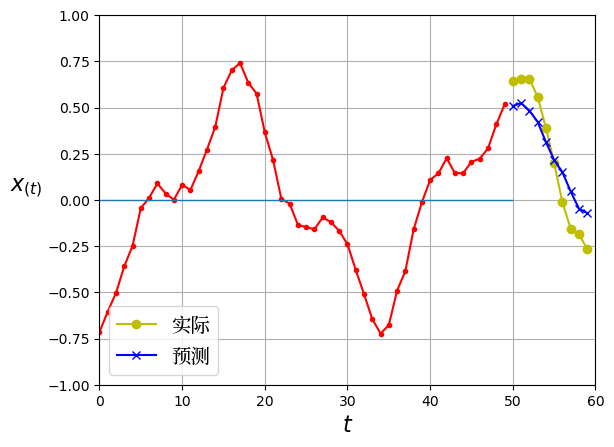

In [65]:
plot_multiple_forecasts(X=X_new, y=y_new, y_pred=y_pred_expend)
plt.show()

In [66]:
model.evaluate(X_val, y_val)

63/63 [==============================] - 0s 2ms/step - loss: 0.0088


0.008809537626802921

该模型在接下来10步的MSE为0.0088,表现要优于`方法三`的线性模型预测.

### 使用RNN 在每个时间步预测多步策略

实际上，我们可以训练模型在**每个时间步预测接下来的 10 个值**，而不是训练模型仅在最后一个时间步预测接下来的 10 个值.

我们可以把`序列到向量的RNN`变成一个`序列到序列的RNN`。优点是:
> 1. 损失将包含 RNN 在每个时间步的输出项，而不仅仅是最后一个时间步长的输出.
2. 这意味着将有更多的误差梯度流经模型,它们还将从每个时间步长的输出中流出.
3.这将稳定并加快训练.

- 例如:模型在时间步长0时会输出一个向量(包括时间步长 1 到 10的预测),以此类推.最后一个它将在最后一个时间步49预测时间步长 50 到 59.
- 每个目标必须是一个与输入序列长度相同的序列，每一步都包含一个 10 维向量.

1. 生成时间序列并创建数据集

In [67]:
initialization(seed=43)

In [68]:
n_steps = 50
ahead = 10

series = generate_time_series(10000, n_steps + ahead)
X_train = series[:7000, :n_steps]  # shape:(7000, 50, 1)
X_val = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

In [69]:
#  steps_ahead - 1:    0     1     2     ...     9
#  -------------- :  1~51  2~52  3~53    ...   10~60  
# 每个时间步长循环获取50个数据
# 目标中包含了在输入中出现的值

In [70]:
Y = np.empty(shape=(10000, n_steps, 10))  # shape:(10000, 50, 10)
for steps_ahead in range(1, ahead + 1):
    Y[..., steps_ahead - 1] = series[..., steps_ahead:steps_ahead + n_steps, 0]

In [71]:
Y_train = Y[:7000]
Y_val = Y[7000:9000]
Y_test = Y[9000:]
 
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

2. 构建RNN模型

要将模型变成`序列到序列`的模型，必须在所有循环层中设置`return_sequence=True`，并且我们必须在每个时间步应用输出 `Dense 层`。 
<img src="../images/other/15-7.png" width="400">

`Keras` 提供了`TimeDistributed层`：**它包装任何层（例如 `Dense 层`）并在其输入序列的每个时间步应用它**。它通过重构输入来有效地做到这一点，以便**每个时间步都被视为一个单独的实例.**

- 例如,它将输入从`[batch_size, time_steps, input_dimensions]`重塑为`[batch_size × time_steps, input_dimensions]`；
    - 以下的例子中，输入维度的数量是20，因为前面的`SimpleRNN`层有20个单元.
- 然后它执行`Dense 层`.
- 最后，它将输出重构为序列（即输出重构回 `[batch size, time step, output dimensions]`)；
    - 以下的例子中，输出维度的数量为 10，因为`Dense 层`有 10 个单元）。
    - `TimeDistributed(Dense(n))层`等价于 `Conv1D(n, filter_size=1) 层`. 
    - `Dense 层`实际上**支持序列作为输入**,这意味着它仅应用于最后一个输入维度（独立于所有时间步长）。因此，我们可以只用 `Dense(10)` 替换最后一层.

In [72]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

3. 自定义评估指标

    尽管我们要依赖在所有输出的 MSE 进行训练，但我们将使用自定义指标进行评估，**仅在最后一个时间步计算输出上的 MSE**.

In [73]:
def last_time_step_mse(y_true, y_pred):
    return keras.losses.mean_squared_error(y_true[:, -1, :], 
                                           y_pred[:, -1, :])

4. 训练及评估

In [74]:
Adam = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer=Adam, 
              metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train,
                    epochs=20,
                    validation_data=(X_val, Y_val))

Epoch 1/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0510 - last_time_step_mse: 0.0403 - val_loss: 0.0426 - val_last_time_step_mse: 0.0300
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0368 - last_time_step_mse: 0.0244 - val_loss: 0.0334 - val_last_time_step_mse: 0.0212
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0322 - last_time_step_mse: 0.0197 - val_loss: 0.0304 - val_last_time_step_mse: 0.0165
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0290 - last_time_step_mse: 0.0166 - val_loss: 0.0306 - val_last_time_step_mse: 0.0197
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0272 - last_time_step_mse: 0.0156 - val_loss: 0.0269 - val_last_time_step_mse: 0.0154
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0242 - last_time_step_mse: 0.0121 - val_loss: 0.0236 - val_last_time_step_mse: 0.0109
Epoch 7/20
219/219 [========

In [75]:
model.evaluate(X_val, Y_val) 

63/63 [==============================] - 0s 2ms/step - loss: 0.0190 - last_time_step_mse: 0.0075


[0.018962040543556213, 0.007476713042706251]

验证集上的MSE为0.0071,相较`方法4`使用RNN一次多步预测策略MSE=0.0088,提升了20%的性能.

5. 绘制时间序列

In [76]:
initialization(seed=43)

series = generate_time_series(1, n_steps+10)  # shape:(1, 60, 1)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]

Y_pred = model.predict(X_new)[: ,-1]
Y_pred_expend = Y_pred[..., np.newaxis]   # shape:(1, 10, 1)

1/1 [==============================] - 0s 116ms/step


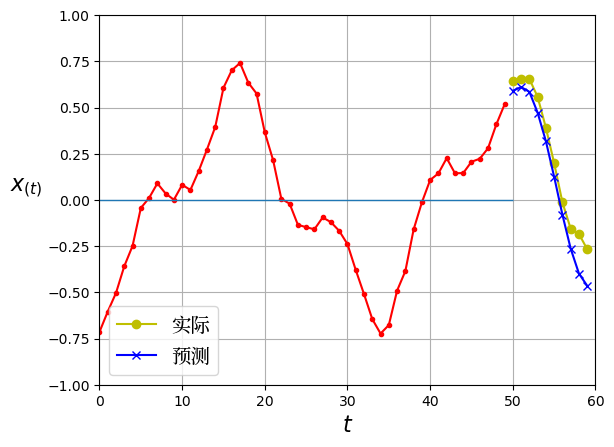

In [77]:
plot_multiple_forecasts(X_new, Y_new, Y_pred_expend)
plt.show()

您可以将此方法与`方法1`结合使用：只需使用此 RNN 预测接下来的 10 个值，然后将这些值合并到输入时间序列并再次使用模型来预测接下来的 10 个值，并根据需要重复该过程多次.

使用这种方法，您可以生成任意长的序列。对于长期预测，它可能不是很准确，但如果你的目标是生成原创音乐或文本，它可能会很好，正如我们将在`第 16 章`中看到的那样。

# 处理长序列 Handing Long Sequences

## 应对不稳定梯度 Fighting the Unstable Gradients Problem

我们在深度网络中用于缓解不稳定梯度问题的许多技巧也可以使用在RNN中:**良好的参数初始化、更快的优化器、dropout** 等.

###  激活函数

非饱和激活函数（例如，`ReLU`）实际上可能会导致 RNN 在训练过程中变得更加不稳定。

- 首先，是可以使用`ReLU`作为激活函数的，并且在序列较短、网络较浅时`ReLU`表现优于`tanh`，但是当序列变长、网络加深后，效果就比`tanh`差；
- 因为`ReLU`的输出可能大于1，当序列过长时，会累计相乘多个大于1的数，最后输出可能会造成**梯度爆炸**，但是使用`tanh`激活函数，能够将输出值限制在-1和1之间。
- 由于`ReLU`是输出是非负的，这样在递归相乘时就只会保留大于等于0的部分，而`tanh`这种以0中心对称的激活函数可以决定保留哪些信息、去除哪些信息。

RNN的**梯度爆炸**问题比较容易解决，一般通过`权重衰减`或`梯度截断`来避免。

- `权重衰减`是通过给参数增加$l_1$或$l_2$范数的正则化项来限制参数的取值范围，从而使得$\gamma≤1$.
- `梯度截断Gradient Clipping `是另一种有效的启发式方法，如果梯度变得非常大，那么我们就调节它使其保持较小的状态，使它们永远不会超过某个阈值.最常用于`循环神经网络RNN`.
    
    参考:https://blog.csdn.net/qq_34769162/article/details/111171116
    
    所有Keras优化器都接受`clipnorm`或`clipvalue`参数.
    - `clipvalue`优化器会将梯度向量的每个分量都裁切为-1.0~1.0之间的值。
    
    - 要确保梯度裁剪不更改梯度向量的方向,通过设置`clipnorm`而不是`clipvalue`来实现

In [78]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss=keras.losses.mse, optimizer=optimizer)

### 逐层归一化

#### 批量归一化BN

   - RNN中`批量标准化BN`不能在时间步长之间使用它，**只能在递归层之间使用**。更准确地说，在技术上可以将 `BN 层`添加到记忆单元中.
   - 但是，无论输入和隐藏状态的实际比例和偏移量如何，每个时间步都将使用相同的 `BN 层`，具有相同的参数。在实践中，**这不会产生好的结果**.
   - `BN层` 仅在应用于输入而非隐藏状态时才略微有益。换句话说，当在循环层之间应用时（下图左侧），它总比没有好.
       <img src="../images/other/15-6.png" width="400">
        
   - 在`Keras` 中，这可以简单地通过在每个循环层之前添加一个 `BatchNormalization层`来完成，但不要期望太多。

In [79]:
initialization(seed=42)

In [80]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),   # 应用于输入
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train,
                    epochs=20,
                    validation_data=(X_val, Y_val))

Epoch 1/20
219/219 [==============================] - 3s 8ms/step - loss: 0.1935 - last_time_step_mse: 0.1928 - val_loss: 0.0899 - val_last_time_step_mse: 0.0850
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0527 - last_time_step_mse: 0.0443 - val_loss: 0.0548 - val_last_time_step_mse: 0.0459
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0467 - last_time_step_mse: 0.0377 - val_loss: 0.0452 - val_last_time_step_mse: 0.0352
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0434 - last_time_step_mse: 0.0341 - val_loss: 0.0428 - val_last_time_step_mse: 0.0330
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0410 - last_time_step_mse: 0.0313 - val_loss: 0.0406 - val_last_time_step_mse: 0.0306
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0387 - last_time_step_mse: 0.0285 - val_loss: 0.0383 - val_last_time_step_mse: 0.0274
Epoch 7/20
219/219 [========

#### 层归一化LN

   - 批量归一化是对一个中间层的单个神经元进行归一化操作, 因此要求小批量样本的数量不能太小, 否则难以计算单个神经元的统计信息. 此外, 如果一个神经元的净输入的分布在神经网络中是动态变化的, **比如RNN, 那么就无法应用批量归一化操作.**
     
   - `层归一化Layer Normalization`是和`批量归一化`非常类似的方法. 和批量归一化不同的是, **层归一化是对一个中间层的所有神经元进行归一化.**
    
    > 对于一个深度神经网络, 令第 $l$ 层神经元的净输入为 $z^{(l)}$, 其均值和方差为
    $$
    \begin{aligned}
    \mu^{(l)} &=\frac{1}{M_{l}} \sum_{i=1}^{M_{l}} z_{i}^{(l)}, \\
    \sigma^{(l)^{2}} &=\frac{1}{M_{l}} \sum_{i=1}^{M_{l}}\left(z_{i}^{(l)}-\mu^{(l)}\right)^{2},
    \end{aligned}
    $$
    其中 $M_{l}$ 为第 $l$ 层神经元的数量.
    
    > `层归一化`定义为
    $$
    \begin{aligned}
    \hat{z}^{(l)} &=\frac{\boldsymbol{z}^{(l)}-\mu^{(l)}}{\sqrt{\sigma^{(l)^{2}}+\epsilon}} \odot \gamma+\beta \\
    & \triangleq \mathrm{LN}_{\gamma, \beta}\left(z^{(l)}\right),
    \end{aligned}
    $$
    其中 $\gamma$ 和 $\beta$ 分别代表缩放和平移的参数向量, 和 $z^{(l)}$ 维数相同.
    
   - RNN中的`层归一化 `
   
       `层归一化`可以应用在RNN中, 对循环神经层进行归一化操作. 
       > 假设在时刻 $t$, 循环神经网络的隐藏层为 $\boldsymbol{h}_{t}$, 其层归一化的 更新为
    $$
    \begin{aligned}
    &z_{t}=\boldsymbol{U} \boldsymbol{h}_{t-1}+\boldsymbol{W} \boldsymbol{x}_{t}, \\
    &\boldsymbol{h}_{t}=f\left(\mathrm{LN}_{\boldsymbol{\gamma}, \beta}\left(z_{t}\right)\right),
    \end{aligned}
    $$
    其中输入为 $x_{t}$ 为第 $t$ 时刻的输入, $U$ 和 $W$ 为网络参数.
    
    在标准RNN中, 循环神经层的净输入一般会随着时间慢慢变大或变小, 从而导致梯度爆炸或消失. 而**层归一化的循环神经网络可以有效地缓解这种状况.**
    
    `层归一化`和`批量归一化`整体上是十分类似的, 差别在于归一化的方法不同. 
    - 对于 $K$ 个样本的一个小批量集合 $\boldsymbol{Z}^{(l)}=\left[z^{(1, l)} ; \cdots ; z^{(K, l)}\right]$
        - `层归一化`是对矩阵 $\boldsymbol{Z}^{(l)}$ 的每一列进行归一化, 
        - `批量归一化`是对每一行进行归一化. 
    
    一般而言,`批量归一化`是一种更好的选择. 当小批量样本数量比较小时, 可以选择`层归一化`.

#### 批量归一化BN vs 层归一化LN

<img src="../images/other/15-8.png" width="400">

- `批量归一化`是对这批所有样本的各个特征维度分别做归一化（6次），`层归一化`是对这单个样本的所有特征维度做归一化（3次）
- 将输入的图像shape记为`[N, C, H, W]`，这几个方法主要的区别就是在
    
    `N_y` 表示样本轴，  `C_x`表示通道轴，  `F_z`是每个通道的特征数量
    - `批量归一化`是**先一个通道**（在多层神经元中就是某一层的纬度或者神经元的节点数目），接着在同一批所有样本的的一个(independent)特征，一个(independent)特征的做归一化, （或者说在batch上，对NHW做归一化），然后**再下一个通道**（对小batchsize效果不好）
    <img src="../images/other/15-9.png" width="200">
    - `层归一化`则是**先一个样本**，一个通道的所有特征维度，一个通道的所有特征维度做归一化。（或者说对CHW做归一化）,然后**下一个样本**.
    <img src="../images/other/15-10.png" width="200">

#### 层归一化的实现

使用`keras` 在一个简单的记忆单元中实现层规范化。为此，我们需要定义一个自定义存储单元。

- `call()`有两个参数：`inputs当前时间步的输入`和`states前一个时间步长的隐藏状态`。`states`是一个包含一个或多个张量的列表.
- 在一个简单的 RNN 单元，它包含的 单个张量 等于 前一个时间步长的输出 ，但其他单元可能有多个状态张量（例如，一个 LSTM 单元有一个长期状态和一个短期状态）。一个单元格还必须有一个 `state_size` 属性和一个 `output_size` 属性。**在一个简单的 RNN 中，两者都等于单元数。**

1. **自定义记忆单元**

    以下所实现的是一个类似`SimpleRNNCell`自定义记忆单元, 同时实现了在每个时间步长应用了`层归一化`.
    
    - `tf.keras.layers.LayerNormalization`

    在一个批次中“独立地”对“每个给定示例”的前一层的激活进行归一化，而不是像批量标准化那样“跨批次”。即应用一个保持“在每个示例中”的平均激活接近于0的变换,并且激活标准差接近 1。

    - `keras.layers.SimpleRNNCell`
    
    处理整个时间序列输入中的一个时间步长，而 `tf.keras.layer.SimpleRNN` 处理整个序列。
        - `inputs`：一个二维张量，形状为 `[batch, feature]`.
        - `states`：形状为 `[batch, units]` 的二维张量，它是上一个时间步的状态.

  对于0时间步，用户提供的初始状态将被馈送到单元格.
  
  `SimpleRNNCell`，它计算当前输入和先前隐藏状态的线性组合，它会返回两个结果（实际上，在一个`SimpleRNNCell`中，输出正好等于隐藏状态states：换句话说，`new_state[0]`等于`outputs`.

In [81]:
class LNSimpleRNNCell(keras.layers.Layer):

    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units

        # 处理整个时间序列输入中的一个步骤
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(
            units=units, activation=activation)

        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        # RNN 层初始状态的张量或张量列表
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]

    def call(self, inputs, states):
        outputs, new_state = self.simple_rnn_cell(inputs, states)
        norm = self.layer_norm(outputs)
        # 在激活函数之前执行层归一化
        norm_outputs = self.activation(norm)
        # 返回两个输出:一个作为输出, 一个作为新的隐藏状态
        return norm_outputs, [norm_outputs]

从` keras.layers.SimpleRNNCell` 继承会更简单，这样就不必创建内部`SimpleRNNCell`或处理`outputs`, `new_state`.

2. **生成时间序列并创建数据集**

In [82]:
initialization(seed=43)

In [83]:
n_steps = 50
ahead = 10

series = generate_time_series(10000, n_steps + ahead)
X_train = series[:7000, :n_steps]  # shape:(7000, 50, 1)
X_val = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

In [84]:
Y = np.empty(shape=(10000, n_steps, 10))  # shape:(10000, 50, 10)
for steps_ahead in range(1, ahead + 1):
    Y[..., steps_ahead - 1] = series[..., steps_ahead:steps_ahead + n_steps, 0]

In [85]:
Y_train = Y[:7000]
Y_val = Y[7000:9000]
Y_test = Y[9000:]
 
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

2. **构建RNN模型,训练及评估**

In [86]:
initialization(seed=42)

In [87]:
model = keras.models.Sequential([
    # simple_rnn_cell==>layers_norm==>activation==>simple_rnn_cell==>...
    # RNN():循环神经网络层基类
    keras.layers.RNN(LNSimpleRNNCell(20),
                     return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(10), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10)),
])

In [88]:
def last_time_step_mse(y_true, y_pred):
    return keras.losses.mean_squared_error(y_true[:, -1, :], 
                                           y_pred[:, -1, :])

In [89]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

history = model.fit(X_train,Y_train,
                    epochs=20,
                    validation_data=(X_val, Y_val))

Epoch 1/20
219/219 [==============================] - 5s 16ms/step - loss: 0.1828 - last_time_step_mse: 0.1726 - val_loss: 0.0747 - val_last_time_step_mse: 0.0666
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0676 - last_time_step_mse: 0.0584 - val_loss: 0.0632 - val_last_time_step_mse: 0.0548
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0607 - last_time_step_mse: 0.0520 - val_loss: 0.0585 - val_last_time_step_mse: 0.0502
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0567 - last_time_step_mse: 0.0481 - val_loss: 0.0556 - val_last_time_step_mse: 0.0470
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0533 - last_time_step_mse: 0.0449 - val_loss: 0.0519 - val_last_time_step_mse: 0.0432
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0502 - last_time_step_mse: 0.0413 - val_loss: 0.0489 - val_last_time_step_mse: 0.0399
Epoch 7/20
219/219 [==

同样, 可以创建一个自定义单元以在每个时间步长之间应用`dropout`。

另外, 所有循环层（`keras.layers.RNN` 除外）和 `Keras` 提供的所有单元都提供了曹参数：

   - `dropout`: 在 0 和 1 之间的浮点数。 单元的丢弃比例，**用于输入的线性转换**。
   - `recurrent_dropout`: **用于循环层状态的线性转换**。

前者定义了应用于输入的 `dropout` 率（每个时间步长），后者定义了隐藏状态的 `dropout` 率（每个时间步长）。


### 创建自定义 RNN 类

<img src="../images/other/15-12.png" width="500">

In [90]:
class MyRNN(keras.layers.Layer):

    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(self.cell, "get_initial_state",
                                         self.fallback_initial_state)

    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [
            tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)
        ]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [91]:
initialization(seed=42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train,
                    epochs=20,
                    validation_data=(X_val, Y_val))

Epoch 1/20
219/219 [==============================] - 5s 17ms/step - loss: 0.2121 - last_time_step_mse: 0.2171 - val_loss: 0.0873 - val_last_time_step_mse: 0.0813
Epoch 2/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0717 - last_time_step_mse: 0.0640 - val_loss: 0.0626 - val_last_time_step_mse: 0.0550
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0577 - last_time_step_mse: 0.0495 - val_loss: 0.0540 - val_last_time_step_mse: 0.0453
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0504 - last_time_step_mse: 0.0411 - val_loss: 0.0484 - val_last_time_step_mse: 0.0388
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0452 - last_time_step_mse: 0.0353 - val_loss: 0.0436 - val_last_time_step_mse: 0.0330
Epoch 6/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0419 - last_time_step_mse: 0.0315 - val_loss: 0.0411 - val_last_time_step_mse: 0.0308
Epoch 7/20
219/219 [==

## 解决短期记忆问题 Tackling the Short-Term Memory Problem

### LSTM单元

- `keras`中使用`keras.layers.LSTM()`实现长短期记忆网络.
```python
lstm, state_h, state_c = LSTM(,return_sequences=True, return_state=True)
# 返回：
# lstm：每个时间步的隐藏状态
# state_h：最后一个时间步的隐藏状态
# state_c：最后一个时间步的cell状态
```

In [92]:
initialization(seed=42)

In [93]:
# GPU加速
# from tensorflow.compat.v1.keras.layers import CuDNNLSTM
# model = keras.models.Sequential([
#     CuDNNLSTM(20, return_sequences=True, input_shape=[None,1]),
#     CuDNNLSTM(20, return_sequences=True),
#     keras.layers.TimeDistributed(keras.layers.Dense(10))
# ])

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [94]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train,
                    epochs=20,
                    validation_data=(X_val, Y_val))

Epoch 1/20
219/219 [==============================] - 5s 15ms/step - loss: 0.0762 - last_time_step_mse: 0.0624 - val_loss: 0.0567 - val_last_time_step_mse: 0.0402
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0480 - last_time_step_mse: 0.0284 - val_loss: 0.0423 - val_last_time_step_mse: 0.0209
Epoch 3/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0389 - last_time_step_mse: 0.0187 - val_loss: 0.0367 - val_last_time_step_mse: 0.0156
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0348 - last_time_step_mse: 0.0151 - val_loss: 0.0339 - val_last_time_step_mse: 0.0141
Epoch 5/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0322 - last_time_step_mse: 0.0134 - val_loss: 0.0319 - val_last_time_step_mse: 0.0126
Epoch 6/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0306 - last_time_step_mse: 0.0124 - val_loss: 0.0306 - val_last_time_step_mse: 0.0126
Epoch 7/20
219/219 [==

In [95]:
model.evaluate(X_val, Y_val)

63/63 [==============================] - 0s 3ms/step - loss: 0.0237 - last_time_step_mse: 0.0086


[0.023712575435638428, 0.008570396341383457]

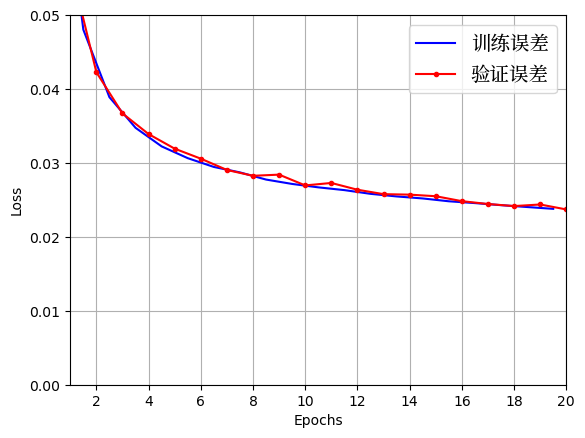

In [96]:
plot_lr_curves(history.history["loss"], history.history["val_loss"], 20)
plt.show()

- 或者可以使用通用的 `keras.layers.RNN()`, 给它一个 `LSTM 单元`作为参数

In [97]:
model_Universal_LSTM = keras.models.Sequential([
    keras.layers.RNN(keras.layers.LSTMCell(20),
                     return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

- 绘制时间序列:

In [98]:
initialization(seed=43)

In [99]:
series = generate_time_series(1, n_steps+10)  # shape:(1, 60, 1)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]

Y_pred = model.predict(X_new)[: ,-1]
Y_pred_expend = Y_pred[..., np.newaxis]   # shape:(1, 10, 1)

1/1 [==============================] - 0s 384ms/step


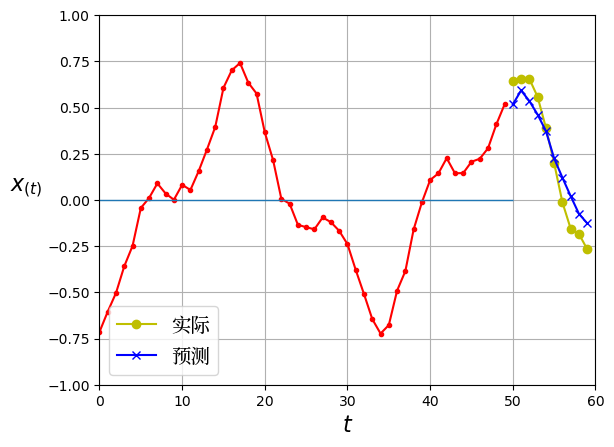

In [100]:
plot_multiple_forecasts(X_new, Y_new, Y_pred_expend)
plt.show()

### LSTM原理

<img src="../images/other/15-15.png" width="500">

> - LSTM计算等式
> $$\begin{aligned} \boldsymbol{i}_{t} &=\sigma\left(\boldsymbol{W}_{i} \boldsymbol{x}_{t}+\boldsymbol{U}_{i} \boldsymbol{h}_{t-1}+\boldsymbol{b}_{i}\right) \\
\boldsymbol{f}_{t} &=\sigma\left(\boldsymbol{W}_{f} \boldsymbol{x}_{t}+\boldsymbol{U}_{f} \boldsymbol{h}_{t-1}+\boldsymbol{b}_{f}\right), \\ 
\boldsymbol{o}_{t} &=\sigma\left(\boldsymbol{W}_{o} \boldsymbol{x}_{t}+\boldsymbol{U}_{o} \boldsymbol{h}_{t-1}+\boldsymbol{b}_{o}\right)  \\
\boldsymbol{c}_{t} &=\boldsymbol{f}_{t} \odot \boldsymbol{c}_{t-1}+\boldsymbol{i}_{t} \odot \tilde{\boldsymbol{c}}_{t}, \\
\boldsymbol{h}_{t} &=\boldsymbol{o}_{t} \odot \tanh \left(\boldsymbol{c}_{t}\right) \\
\boldsymbol{c}_{t} &=\tanh \left(\boldsymbol{W}_{c} \boldsymbol{x}_{t}+\boldsymbol{U}_{c} \boldsymbol{h}_{t-1}+\boldsymbol{b}_{c}\right) 
\end{aligned}$$

<img src="../images/other/15-11.jpg">
<img src="../images/other/15-13.jpg">
<img src="../images/other/15-14.jpg">

一般在深度网络参数学习时，参数初始化的值一般都比较小。但是在训练`LSTM`网络时，过小的值会使得遗忘门的值比较小这意味着前一时刻的信息大部分都丢失了，这样网络很难捕捉到长距离的依赖信息。并且相邻时间间隔的梯度会非常小，这会导致`梯度弥散`问题。因此**遗忘的参数初始值一般都设得比较大，其偏置向量$b_f$设为1或2.**

### Peephole连接

`窥视孔连接 Peephole connection`是三个门不但依赖于输入 $\boldsymbol{x}_{t}$ 和上一时刻的隐状态 $\boldsymbol{h}_{t-1}$, 也**依赖于上一个时刻的记忆单元 $\boldsymbol{c}_{t-1}$**, 即
> $$
\begin{aligned}
\boldsymbol{i}_{t} &=\sigma\left(\boldsymbol{W}_{i} \boldsymbol{x}_{t}+\boldsymbol{U}_{i} \boldsymbol{h}_{t-1}+\boldsymbol{V}_{i} \boldsymbol{c}_{t-1}+\boldsymbol{b}_{i}\right) \\
\boldsymbol{f}_{t} &=\sigma\left(\boldsymbol{W}_{f} \boldsymbol{x}_{t}+\boldsymbol{U}_{f} \boldsymbol{h}_{t-1}+\boldsymbol{V}_{f} \boldsymbol{c}_{t-1}+\boldsymbol{b}_{f}\right) \\
\mathbf{o}_{t} &=\sigma\left(\boldsymbol{W}_{o} \boldsymbol{x}_{t}+\boldsymbol{U}_{o} \boldsymbol{h}_{t-1}+\boldsymbol{V}_{o} \boldsymbol{c}_{t}+\boldsymbol{b}_{o}\right)
\end{aligned}
$$
>其中 $V_{i}, V_{f}$ 和 $V_{o}$ 为对角矩阵.

peephole 连接 另外一种变体是三个门不但依赖于输入 $\boldsymbol{x}_{t}$ 和上一时刻的隐状 态 $\boldsymbol{h}_{t-1}$, 也依赖于上一个时刻的记忆单元 $\boldsymbol{c}_{t-1}$, 即
$$
\begin{aligned}
\boldsymbol{i}_{t} &=\sigma\left(\boldsymbol{W}_{i} \boldsymbol{x}_{t}+\boldsymbol{U}_{i} \boldsymbol{h}_{t-1}+\boldsymbol{V}_{i} \boldsymbol{c}_{t-1}+\boldsymbol{b}_{i}\right) \\
\boldsymbol{f}_{t} &=\sigma\left(\boldsymbol{W}_{f} \boldsymbol{x}_{t}+\boldsymbol{U}_{f} \boldsymbol{h}_{t-1}+\boldsymbol{V}_{f} \boldsymbol{c}_{t-1}+\boldsymbol{b}_{f}\right) \\
\mathbf{o}_{t} &=\sigma\left(\boldsymbol{W}_{o} \boldsymbol{x}_{t}+\boldsymbol{U}_{o} \boldsymbol{h}_{t-1}+\boldsymbol{V}_{o} \boldsymbol{c}_{t}+\boldsymbol{b}_{o}\right)
\end{aligned}
$$
其中 $V_{i}, V_{f}$ 和 $V_{o}$ 为对角矩阵.
<img src="../images/other/15-16.png" width="500">

### GRU单元

<img src="../images/other/15-17.png" width="600">

> - GRU计算等式
$$
\boldsymbol{h}_{t}=\boldsymbol{z}_{t} \odot \boldsymbol{h}_{t-1}+\left(1-\boldsymbol{z}_{t}\right) \odot g\left(\boldsymbol{x}_{t}, \boldsymbol{h}_{t-1} ; \theta\right),
$$
$$
\boldsymbol{z}_{t}=\sigma\left(\boldsymbol{W}_{z} \boldsymbol{x}_{t}+\boldsymbol{U}_{z} \boldsymbol{h}_{t-1}+\boldsymbol{b}_{z}\right) .
$$
$$
\tilde{\boldsymbol{h}}_{t}=\tanh \left(\boldsymbol{W}_{h} \boldsymbol{x}_{t}+\boldsymbol{U}_{h}\left(\boldsymbol{r}_{t} \odot \boldsymbol{h}_{t-1}\right)+\boldsymbol{b}_{h}\right),
$$
$$
\boldsymbol{r}_{t}=\sigma\left(\boldsymbol{W}_{r} \boldsymbol{x}_{t}+\boldsymbol{U}_{r} \boldsymbol{h}_{t-1}+\boldsymbol{b}_{r}\right),
$$
$$
\boldsymbol{h}_{t}=\boldsymbol{z}_{t} \odot \boldsymbol{h}_{t-1}+\left(1-\boldsymbol{z}_{t}\right) \odot \tilde{\boldsymbol{h}}_{t} .
$$

`门控循环单元GRU` 使用了`更新门`（update gate）与`重置门`（reset gate）。基本上，这两个门控向量决定了哪些信息最终能作为门控循环单元的输出。这两个门控机制的特殊之处在于，它们能够保存长期序列中的信息，且不会随时间而清除或因为与预测不相关而移除。 `GRU`的输入输出结构与普通的RNN是一样的。有一个当前的输入 $x_t$ ，和上一个节点传递下来的隐状态（hidden state） $h_{(t-1)}$ ，这个隐状态包含了之前节点的相关信息。结合 $x_t$ 和 $h_{(t-1)}$，`GRU`会得到当前隐藏节点的输出 $y_t$ 和传递给下一个节点的隐状态 $h_t$ 。

详细参考:https://zhuanlan.zhihu.com/p/83220665

- `keras`中使用`keras.layers.GRU()`实现门控循环单元.

In [101]:
initialization(seed=42)

In [102]:
# GPU加速
# from tensorflow.compat.v1.keras.layers import CuDNNGRU
# model = keras.models.Sequential([
#     CuDNNGRU(20, return_sequences=True, input_shape=[None, 1]),
#     CuDNNGRU(20, return_sequences=True),
#     keras.layers.TimeDistributed(keras.layers.Dense(10)),
# ])

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10)),
])

In [103]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

history = model.fit(X_train,Y_train,
                    epochs=20,
                    validation_data=(X_val, Y_val))

Epoch 1/20
219/219 [==============================] - 6s 17ms/step - loss: 0.0739 - last_time_step_mse: 0.0668 - val_loss: 0.0519 - val_last_time_step_mse: 0.0402
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0473 - last_time_step_mse: 0.0368 - val_loss: 0.0444 - val_last_time_step_mse: 0.0331
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0420 - last_time_step_mse: 0.0313 - val_loss: 0.0402 - val_last_time_step_mse: 0.0288
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0381 - last_time_step_mse: 0.0268 - val_loss: 0.0366 - val_last_time_step_mse: 0.0244
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0347 - last_time_step_mse: 0.0227 - val_loss: 0.0340 - val_last_time_step_mse: 0.0207
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0318 - last_time_step_mse: 0.0179 - val_loss: 0.0312 - val_last_time_step_mse: 0.0165
Epoch 7/20
219/219 [==

In [104]:
model.evaluate(X_val, Y_val)

63/63 [==============================] - 0s 3ms/step - loss: 0.0241 - last_time_step_mse: 0.0101


[0.024118490517139435, 0.01008898951113224]

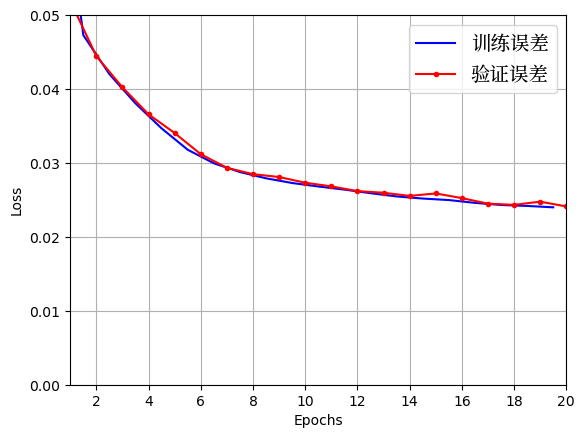

In [105]:
plot_lr_curves(history.history["loss"], history.history["val_loss"], 20)
plt.show()

- 绘制时间序列:

In [106]:
initialization(seed=43)

In [107]:
series = generate_time_series(1, n_steps+10)  # shape:(1, 60, 1)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]

Y_pred = model.predict(X_new)[: ,-1]
Y_pred_expend = Y_pred[..., np.newaxis]   # shape:(1, 10, 1)

1/1 [==============================] - 0s 357ms/step


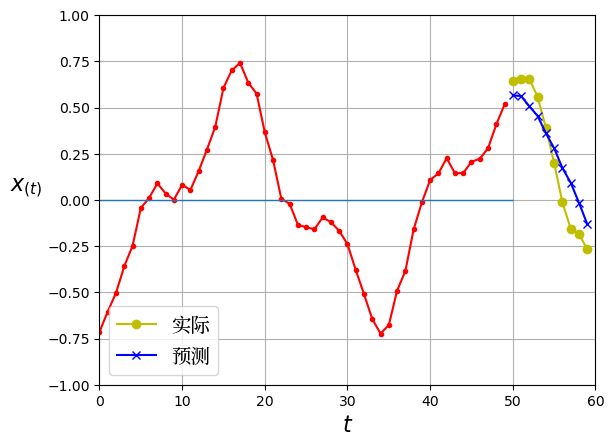

In [108]:
plot_multiple_forecasts(X_new, Y_new, Y_pred_expend)
plt.show()

### 使用一维卷积层处理序列 Using 1D convolutional layers to process sequences

类似与`卷积神经网络`在图像方面的使用，`一维卷积层`也可以在一个序列中滑动多个内核，每个内核生成一个一维特征图。

每个内核将学习检测一个非常短的序列模式（不超过内核大小）。
- 如果您使用步长为 1 和`SAME`填充的一维卷积层，则输出序列将具有与输入序列相同的长度。
- 如果您使用`VAILD`填充或大于 1 的步幅，则输出序列将比输入序列短，因此请确保相应地调整目标。


```

例如: 一维卷积层，内核大小为 4，步幅为 2(内核大小大于步幅)，VALID填充：

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

输出:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

- 通过缩短序列，**卷积层可以帮助 GRU 层检测更长的模式**。
- 请注意，我们还必须**裁剪目标中的前三个时间步长.**
- 对目标进行2倍的下采样

In [109]:
# 内核大小为4, index_start=0  -->  4-1=3
# strides=2 --> 2倍下采样
Y_train_crops = Y_train[:, 3::2, :]  # shape:(7000, 24, 10)
Y_val_crops = Y_val[:, 3::2, :]  # shape:(2000, 24, 10)

In [110]:
initialization(42)

In [111]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20,
                        kernel_size=4,
                        strides=2,
                        padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [112]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train_crops,
                    epochs=20, 
                    validation_data=(X_val, Y_val_crops))

Epoch 1/20
219/219 [==============================] - 4s 10ms/step - loss: 0.0680 - last_time_step_mse: 0.0612 - val_loss: 0.0475 - val_last_time_step_mse: 0.0390
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0407 - last_time_step_mse: 0.0340 - val_loss: 0.0371 - val_last_time_step_mse: 0.0297
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0332 - last_time_step_mse: 0.0256 - val_loss: 0.0305 - val_last_time_step_mse: 0.0210
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0276 - last_time_step_mse: 0.0178 - val_loss: 0.0268 - val_last_time_step_mse: 0.0159
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0245 - last_time_step_mse: 0.0137 - val_loss: 0.0241 - val_last_time_step_mse: 0.0124
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0231 - last_time_step_mse: 0.0123 - val_loss: 0.0228 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [=======

In [113]:
model.evaluate(X_val, Y_val_crops)

63/63 [==============================] - 0s 2ms/step - loss: 0.0181 - last_time_step_mse: 0.0074


[0.018063830211758614, 0.007432599551975727]

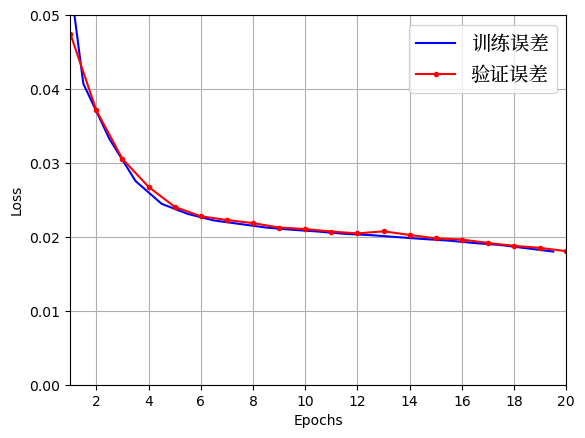

In [114]:
plot_lr_curves(history.history["loss"], history.history["val_loss"], 20)
plt.show()

- 绘制时间序列:

In [115]:
initialization(seed=43)

In [116]:
series = generate_time_series(1, n_steps+10)  # shape:(1, 60, 1)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]

Y_pred = model.predict(X_new)[: ,-1]
Y_pred_expend = Y_pred[..., np.newaxis]   # shape:(1, 10, 1)

1/1 [==============================] - 0s 364ms/step


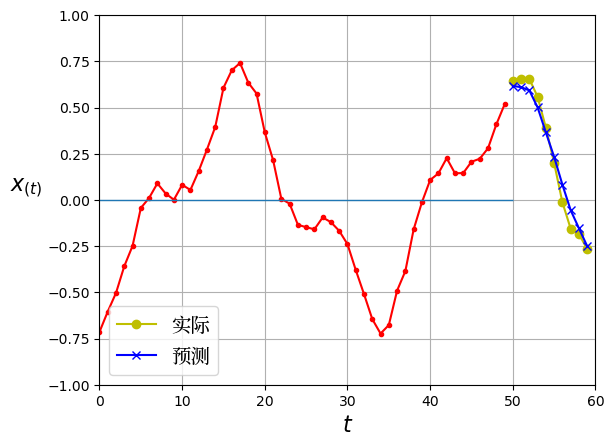

In [117]:
plot_multiple_forecasts(X_new, Y_new, Y_pred_expend)
plt.show()

### WaveNet

`WaveNet`论文中,堆叠了 1D 卷积层，**使每一层的`扩散率`（每个神经元输入的分散程度）加倍**：第一个卷积层一次只能看到两个时间步长，而下一个卷积层看到四个时间步长（它的感受野是四个时间步长），下一个是八个时间步长，依此类推.

这样，较低层学习短期模式，而较高层学习长期模式。由于`扩散率`加倍，网络可以非常有效地处理非常大的序列.

`WaveNet`模型网络形式为`Dilated Casual Convolutions`，每个卷积层都对前一层进行卷积，卷积核越大，层数越多，时域上的感知能力越强，感知范围越大。在生成过程中，每生成一个点，把该点放到输入层最后一个点继续迭代生成即可。

<img src="../images/other/15-18.png" width="400">

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

#### 简化版本的`WaveNet`

In [118]:
initialization(seed=42)

`padding="causal"` 这确保了卷积层在进行预测时不会窥视未来
（相当于在输入的**左侧用正确数量的零并使用`valid`填充**）

得益于填充层，每个卷积层都输出与输入序列长度相同的序列，因此我们在训练期间使用的目标可以是完整序列：无需裁剪或下采样。

In [119]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:  # (1, 2, 4, 8, 1, 2, 4, 8)
    model.add(
        keras.layers.Conv1D(filters=20,
                            kernel_size=2,
                            padding="causal",
                            activation="relu",
                            dilation_rate=rate))
model.add(keras.layers.Conv1D(
    filters=10, kernel_size=1))  #default padding="valid",strides=1,

In [120]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train,
                    epochs=20, 
                    validation_data=(X_val, Y_val))

Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0695 - last_time_step_mse: 0.0569 - val_loss: 0.0392 - val_last_time_step_mse: 0.0241
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0336 - last_time_step_mse: 0.0201 - val_loss: 0.0301 - val_last_time_step_mse: 0.0169
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0288 - last_time_step_mse: 0.0167 - val_loss: 0.0273 - val_last_time_step_mse: 0.0151
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0265 - last_time_step_mse: 0.0147 - val_loss: 0.0262 - val_last_time_step_mse: 0.0139
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0255 - last_time_step_mse: 0.0137 - val_loss: 0.0250 - val_last_time_step_mse: 0.0127
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0249 - last_time_step_mse: 0.0132 - val_loss: 0.0248 - val_last_time_step_mse: 0.0128
Epoch 7/20
219/219 [========

In [121]:
model.evaluate(X_val, Y_val)

63/63 [==============================] - 0s 1ms/step - loss: 0.0212 - last_time_step_mse: 0.0092


[0.02115717902779579, 0.00924447551369667]

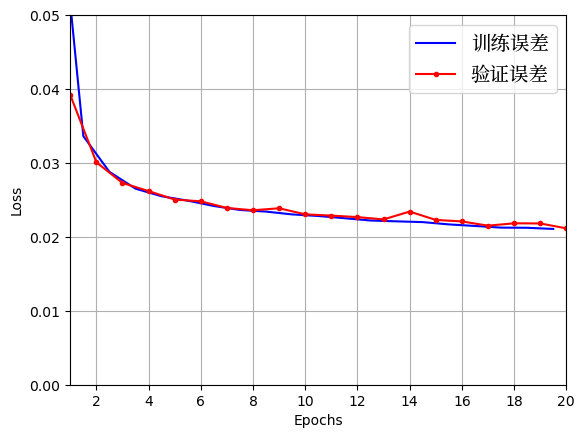

In [122]:
plot_lr_curves(history.history["loss"], history.history["val_loss"], 20)
plt.show()

- 绘制时间序列:

In [123]:
initialization(seed=43)

In [124]:
series = generate_time_series(1, n_steps+10)  # shape:(1, 60, 1)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]

Y_pred = model.predict(X_new)[: ,-1]
Y_pred_expend = Y_pred[..., np.newaxis]   # shape:(1, 10, 1)

1/1 [==============================] - 0s 115ms/step


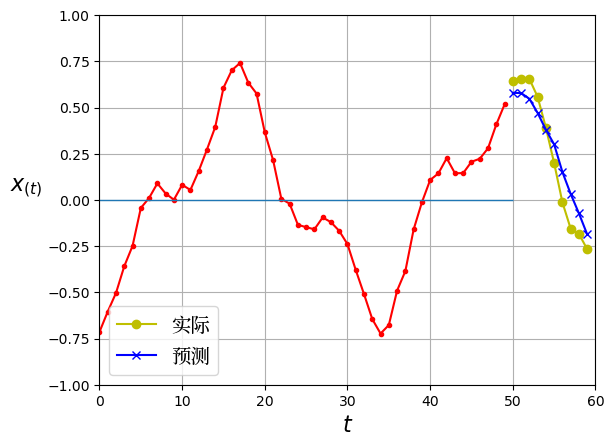

In [125]:
plot_multiple_forecasts(X_new, Y_new, Y_pred_expend)
plt.show()

#### 完整版本的`WaveNet`

这是论文中定义的原始 `WaveNet`：它使用类似于 `Gated Activation Units`和`参数化跳过连接`，另外它在左侧填充零以避免序列越来越短

 - Gated Activation Units:

    `gated activation模块`运用了`tanh`函数于`sigmoid`函数进行相乘，其中$k$是层索引，$f$为滤波器，$g$为一个门，$W$是一个可学习的卷积滤波器。`tanh`和`sigmoid`都属于饱和函数，现在$z$的输出值范围在$（-1，1）$之间,解决了梯度消失问题。

 $${z}=\tanh \left(W_{f, k} * \mathbf{x}\right) \odot \sigma\left(W_{g, k} * \mathbf{x}\right)$$

- Residual and skip connections:

    我们使用了`residual` 和`skip connection`技术来使模型更快收敛，并且使梯度能传到到更深层模型。
    <img src="../images/other/15-19.png" width="600">

In [126]:
class GatedActivationUnit(keras.layers.Layer):

    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [127]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters,
                            kernel_size=2,
                            padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [128]:
initialization(seed=42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 10  # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1,
                              activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [129]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, 
                    epochs=20,
                    validation_data=(X_val, Y_val))

Epoch 1/20
219/219 [==============================] - 2s 5ms/step - loss: 0.1298 - last_time_step_mse: 0.1255 - val_loss: 0.1235 - val_last_time_step_mse: 0.1173
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.1221 - last_time_step_mse: 0.1176 - val_loss: 0.1223 - val_last_time_step_mse: 0.1162
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.1214 - last_time_step_mse: 0.1171 - val_loss: 0.1219 - val_last_time_step_mse: 0.1159
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.1212 - last_time_step_mse: 0.1168 - val_loss: 0.1218 - val_last_time_step_mse: 0.1157
Epoch 5/20
219/219 [==============================] - 1s 5ms/step - loss: 0.1210 - last_time_step_mse: 0.1166 - val_loss: 0.1216 - val_last_time_step_mse: 0.1155
Epoch 6/20
219/219 [==============================] - 1s 5ms/step - loss: 0.1208 - last_time_step_mse: 0.1164 - val_loss: 0.1215 - val_last_time_step_mse: 0.1154
Epoch 7/20
219/219 [========

> create:Apotosome 04/04/22

> update:Apotosome 11/01/22